In [1]:
%load_ext autoreload
%autoreload 2
from Methods import JobOffers,dataframeHelpers

In [2]:
import os
import nltk
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [3]:
autoreload JobOffers,dataframeHelpers

In [4]:
# Only run this if you want to redo the translations
# Start with google and use easynmt if it fails
# JobOffers.writeTranslatedJobs(1000, method="google", fallback=True)

In [5]:
# rawOffers = JobOffers.readJsonFile("Data/output_v1.1.json")

In [6]:
mergedDf = pd.read_csv("Data/mergedJobsAll.csv")

In [7]:
len(mergedDf)

8483

In [8]:
for canton in mergedDf["CANTON1"].value_counts().index[:-1]:
    mergedDf[f"Canton_{canton}"] = mergedDf.apply(lambda x: canton in x["CANTON"], axis=1)

In [9]:
dummies = pd.get_dummies(mergedDf["COMPANY_SIZE"])
mergedDf = mergedDf.join(dummies)

In [10]:
mergedDf["MJ"].value_counts()

1.0    304
0.0    237
Name: MJ, dtype: int64

In [11]:
mergedDf.iloc[0]["TRANSLATED_JOBS"]

'Building leaders Horticultural technician HF The Aemmer AG has been preparing sophisticated and beautiful garden and sports facilities for over 85 years. As a traditional family business with 35 employees and the most modern machinery, we strive to afford proper work. For expanding our team, we are looking for immediate or after agreement building guideline horticultural technician HF their area of \u200b\u200bresponsibility they are involved in the entire expiration of the planning offensea before and construction management to billing. Your areas of responsibility include sophisticated new plant garden change in private and public areas. Our expectations independence as well as joy in working in a team. In addition to flexibility of versatility and commitment should, above all, enjoy the contact with our customers. We offer we offer you a challenging versatile and self-employed activity of a modern dynamic and family operation. A pleasant working atmosphere in a motivated team and a

In [12]:
labeledDf = mergedDf[~mergedDf["MJ"].isna()]

In [13]:
labeledDf

,Unnamed: 0,index,JOB_ID,MJ,ISCO,JOB_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE,NumSentences,...,Canton_GE,Canton_NE,Canton_FR,Canton_VS,Canton_JU,Canton_AR,Large,Micro,Midsize,Small
0,0,0,12047533.0,1.0,31230;12190;21620,['Building leaders Horticultural technician HF...,Building leaders Horticultural technician HF T...,['BE'],Micro,25,...,False,False,False,False,False,False,0,1,0,0
1,1,1,14422389.0,1.0,21620,['As an educational and social education cente...,"As an educational and social education center,...",['BE'],Small,15,...,False,False,False,False,False,False,0,0,0,1
2,2,2,14616465.0,1.0,21420,['Civil Engineer 1804 Corsiersurvey Engineerin...,Civil Engineer 1804 Corsiersurvey Engineering ...,['VD'],Micro,12,...,False,False,False,False,False,False,0,1,0,0
3,3,3,14617343.0,1.0,21620,"['24', ' 05', ' 2017 Internship Landscape Deve...",24. 05. 2017 Internship Landscape Development ...,['BE'],Micro,7,...,False,False,False,False,False,False,0,1,0,0
4,4,4,14515774.0,1.0,21430,['Company portrait The office for the forest o...,Company portrait The office for the forest of ...,['BE'],Midsize,21,...,False,False,False,False,False,False,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8478,8685,120,20933760.0,1.0,24310;24210,"[""Emploi ESDA is looking for a Market Data Ana...",Emploi ESDA is looking for a Market Data Analy...,['GE'],Midsize,12,...,True,False,False,False,False,False,0,0,1,0
8479,8686,121,21930428.0,1.0,26220;41200,"['Org', ' Setting and Reporting This position...",Org. Setting and Reporting This position is l...,['GE'],Midsize,66,...,True,False,False,False,False,False,0,0,1,0
8480,8687,122,22071257.0,1.0,26220,['Caterpillar Graduate Program Junior Busines...,Caterpillar Graduate Program Junior Business ...,['GE'],Large,21,...,True,False,False,False,False,False,1,0,0,0
8481,8688,123,18359929.0,1.0,21490,"['Energy Energy Management Raymond E', ' Moser...",Energy Energy Management Raymond E. Moser has ...,['GE'],Micro,24,...,True,False,False,False,False,False,0,1,0,0


In [14]:
mergedDf

,Unnamed: 0,index,JOB_ID,MJ,ISCO,JOB_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE,NumSentences,...,Canton_GE,Canton_NE,Canton_FR,Canton_VS,Canton_JU,Canton_AR,Large,Micro,Midsize,Small
0,0,0,12047533.0,1.0,31230;12190;21620,['Building leaders Horticultural technician HF...,Building leaders Horticultural technician HF T...,['BE'],Micro,25,...,False,False,False,False,False,False,0,1,0,0
1,1,1,14422389.0,1.0,21620,['As an educational and social education cente...,"As an educational and social education center,...",['BE'],Small,15,...,False,False,False,False,False,False,0,0,0,1
2,2,2,14616465.0,1.0,21420,['Civil Engineer 1804 Corsiersurvey Engineerin...,Civil Engineer 1804 Corsiersurvey Engineering ...,['VD'],Micro,12,...,False,False,False,False,False,False,0,1,0,0
3,3,3,14617343.0,1.0,21620,"['24', ' 05', ' 2017 Internship Landscape Deve...",24. 05. 2017 Internship Landscape Development ...,['BE'],Micro,7,...,False,False,False,False,False,False,0,1,0,0
4,4,4,14515774.0,1.0,21430,['Company portrait The office for the forest o...,Company portrait The office for the forest of ...,['BE'],Midsize,21,...,False,False,False,False,False,False,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8478,8685,120,20933760.0,1.0,24310;24210,"[""Emploi ESDA is looking for a Market Data Ana...",Emploi ESDA is looking for a Market Data Analy...,['GE'],Midsize,12,...,True,False,False,False,False,False,0,0,1,0
8479,8686,121,21930428.0,1.0,26220;41200,"['Org', ' Setting and Reporting This position...",Org. Setting and Reporting This position is l...,['GE'],Midsize,66,...,True,False,False,False,False,False,0,0,1,0
8480,8687,122,22071257.0,1.0,26220,['Caterpillar Graduate Program Junior Busines...,Caterpillar Graduate Program Junior Business ...,['GE'],Large,21,...,True,False,False,False,False,False,1,0,0,0
8481,8688,123,18359929.0,1.0,21490,"['Energy Energy Management Raymond E', ' Moser...",Energy Energy Management Raymond E. Moser has ...,['GE'],Micro,24,...,True,False,False,False,False,False,0,1,0,0


In [15]:
labeledDf["MJ"].astype('bool').value_counts()

True     304
False    237
Name: MJ, dtype: int64

In [16]:
# Only take 2/3 of the "not green" jobs so you have a balanced data set
trainDf = labeledDf[labeledDf.index % 3 != 0]

In [17]:
testDf = labeledDf[labeledDf.index % 3 == 0]

In [18]:
from tensorflow.keras.utils import plot_model

In [19]:
def buildInputs(df):
    normSent = (df["NumSentences"]-df["NumSentences"].mean())/df["NumSentences"].std()
    normChar = (df["NumCharacters"]-df["NumCharacters"].mean())/df["NumCharacters"].std()
    return (df["TRANSLATED_JOBS"].to_numpy(), np.stack(
            (
                normSent, 
                normChar,
                df["Canton_BE"],
                df["Canton_VD"],
                df["Canton_NE"],
                df["Canton_FR"], 
                df["Canton_GE"],
                df["Canton_VS"],
                df["Canton_JU"],
                df["Large"],
                df["Micro"], 
                df["Midsize"],
                df["Small"],
            ), axis=-1))

In [20]:
trainInputs = buildInputs(trainDf)
tf.keras.backend.clear_session()

In [21]:
paragraphInput = tf.keras.layers.Input(shape=(), name="Input", dtype=tf.string)
paragraphEncode = hub.KerasLayer('universal-sentence-encoder_4',
                        input_shape=[], 
                        dtype=tf.string, 
                        trainable=True)(paragraphInput)


In [22]:
paragraphDense = tf.keras.layers.Dense(256, activation='relu')(paragraphEncode)

In [23]:
otherInput = tf.keras.layers.Input(shape=(trainInputs[1].shape[1],))
otherDense = tf.keras.layers.Dense(16,)(otherInput)
mergedLayer = tf.keras.layers.Concatenate()([otherDense, paragraphDense])
denseMerged = tf.keras.layers.Dense(32, activation='relu')(mergedLayer)
output = tf.keras.layers.Dense(1, activation='sigmoid')(denseMerged)

In [24]:
model = tf.keras.Model(inputs=[paragraphInput, otherInput], outputs=output)
model.compile(optimizer='RMSprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [26]:
trainDf["MJ"].value_counts()

1.0    203
0.0    157
Name: MJ, dtype: int64

In [27]:
model.fit(x=buildInputs(trainDf), 
          y=trainDf["MJ"].astype("bool"), 
          validation_data=(buildInputs(testDf), testDf["MJ"].astype("bool")),
          callbacks=[callback],
          epochs=3)

Epoch 1/3
12/12 [==============================] - 16s 660ms/step - loss: 0.6409 - accuracy: 0.6361 - val_loss: 0.5706 - val_accuracy: 0.7624
Epoch 2/3
12/12 [==============================] - 9s 772ms/step - loss: 0.5354 - accuracy: 0.7639 - val_loss: 0.4953 - val_accuracy: 0.7403
Epoch 3/3
12/12 [==============================] - 7s 613ms/step - loss: 0.3204 - accuracy: 0.8889 - val_loss: 0.6357 - val_accuracy: 0.7403


In [28]:
testDf["GREEN_PREDICT_FULL"] = model.predict(x=buildInputs(testDf)) > 0.5

<ipython-input-28-6adb286e861b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDf["GREEN_PREDICT_FULL"] = model.predict(x=buildInputs(testDf)) > 0.5


In [29]:
confusion = pd.crosstab(testDf["MJ"].astype('bool'), testDf["GREEN_PREDICT_FULL"], rownames=['Actual'], colnames=['Predicted'], )
confusion

Predicted,False,True
Actual,,
False,34,46
True,1,100


In [30]:
import seaborn as sn
sn.set(font_scale=1.4)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

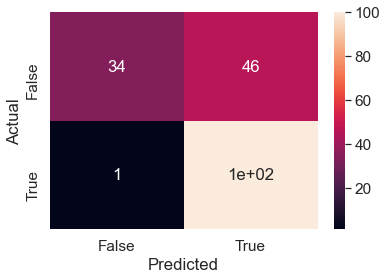

In [31]:
sn.heatmap(confusion, annot=True, )

In [32]:
plot_model(model, to_file='Plots/NeuralNetArch_AllInputs.pdf', show_shapes=True, show_layer_names=True)

In [33]:
trainDf["MJ"].astype('bool').value_counts()

True     203
False    157
Name: MJ, dtype: int64

In [34]:
denseUnmerged = tf.keras.layers.Dense(32, activation='relu')(paragraphDense)
outputUnmerged = tf.keras.layers.Dense(1, activation='sigmoid')(denseUnmerged)

In [35]:
simpleModel = tf.keras.Model(inputs=[paragraphInput], outputs=outputUnmerged)
simpleModel.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [36]:
trainDf["MJ"].astype('bool').value_counts()

True     203
False    157
Name: MJ, dtype: int64

In [37]:
tf.keras.backend.clear_session()
simpleModel.fit(x=[trainDf["TRANSLATED_JOBS"]], 
          y=trainDf["MJ"].astype('bool'), 
          callbacks=[callback],
          validation_data=([testDf["TRANSLATED_JOBS"]], testDf["MJ"].astype('bool'), ),
          epochs=3)

Epoch 1/3
12/12 [==============================] - 30s 2s/step - loss: 0.4066 - accuracy: 0.9167 - val_loss: 0.4327 - val_accuracy: 0.7956
Epoch 2/3
12/12 [==============================] - 22s 2s/step - loss: 0.1066 - accuracy: 0.9917 - val_loss: 0.4978 - val_accuracy: 0.7956
Epoch 3/3
12/12 [==============================] - 21s 2s/step - loss: 0.0329 - accuracy: 0.9944 - val_loss: 0.6134 - val_accuracy: 0.7901


In [38]:
plot_model(simpleModel, to_file='Plots/NeuralNetArch_OnlySentences.pdf', show_shapes=True, show_layer_names=True)

In [39]:
testDf["GREEN_PREDICT_SIMPLE"] = simpleModel.predict(x=[testDf["TRANSLATED_JOBS"]]) > 0.5
confusionSimple = pd.crosstab(testDf["MJ"].astype('bool'), testDf["GREEN_PREDICT_SIMPLE"], rownames=['Actual'], colnames=['Predicted'], )


<ipython-input-39-f437d751fa29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDf["GREEN_PREDICT_SIMPLE"] = simpleModel.predict(x=[testDf["TRANSLATED_JOBS"]]) > 0.5


In [40]:
confusionSimple 

Predicted,False,True
Actual,,
False,57,23
True,15,86


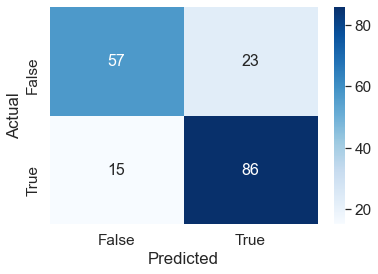

In [41]:
fig = sn.heatmap(confusionSimple, annot=True, cmap="Blues", annot_kws={"size": 16})

In [42]:
fig.figure.tight_layout()
fig.figure.savefig("Plots/simpleModelConfusion.pdf")

In [43]:
mergedDf[mergedDf["TRANSLATED_JOBS"].isna()]

,Unnamed: 0,index,JOB_ID,MJ,ISCO,JOB_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE,NumSentences,...,Canton_GE,Canton_NE,Canton_FR,Canton_VS,Canton_JU,Canton_AR,Large,Micro,Midsize,Small


In [55]:
mergedDf["GREEN_PREDICT_SIMPLE"] = simpleModel.predict(x=[mergedDf["TRANSLATED_JOBS"]]) > 0.5

In [57]:
mergedDf["GREEN_PREDICT_FULL"] = model.predict(x=buildInputs(mergedDf)) > 0.5

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

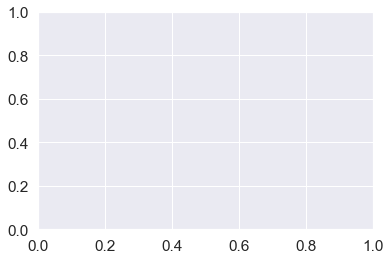

In [58]:
plt.hist(mergedDf["GREEN_PREDICT_SIMPLE"], label="Only text", alpha=0.5)
plt.hist(mergedDf["GREEN_PREDICT_FULL"], label="Full model", alpha=0.5)
plt.legend()

In [56]:
mergedDf["GREEN_PREDICT_SIMPLE"]

0       True
1       True
2       True
3       True
4       True
        ... 
8478    True
8479    True
8480    True
8481    True
8482    True
Name: GREEN_PREDICT_SIMPLE, Length: 8483, dtype: bool

In [47]:
confusionSimple

Predicted,False,True
Actual,,
False,57,23
True,15,86


In [48]:
confMat = confusionSimple.to_numpy()

In [49]:
recall = confMat[0,0]/(confMat[0,0]+confMat[1,0])

In [50]:
precision = confMat[0,0]/(confMat[0,0]+confMat[1,0])

In [51]:
fscore = 2*recall*precision/(recall+precision)

In [52]:
print("Recall: %0.2f\nprecision: %0.2f\nf-score: %0.2f" % (recall, precision, fscore ))

Recall: 0.79
precision: 0.79
f-score: 0.79


In [59]:
mergedDf.to_csv("Results/GreenClassificationFullResults.csv")

In [60]:
mergedDf[mergedDf["GREEN_PREDICT_SIMPLE"] != mergedDf["GREEN_PREDICT_FULL"]]

,Unnamed: 0,index,JOB_ID,MJ,ISCO,JOB_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE,NumSentences,...,Canton_FR,Canton_VS,Canton_JU,Canton_AR,Large,Micro,Midsize,Small,GREEN_PREDICT_SIMPLE,GREEN_PREDICT_FULL
42,42,42,14046630.0,1.0,21620,['Jobs We are looking for landscape gardener y...,Jobs We are looking for landscape gardener you...,['FR'],Small,6,...,True,False,False,False,0,0,0,1,False,True
198,198,198,14236191.0,0.0,12190;24210,"['Team Leader Supplier Quality Engineer Ref', ...",Team Leader Supplier Quality Engineer Ref. 221...,['FR'],Small,14,...,True,False,False,False,0,0,0,1,False,True
308,308,308,12941506.0,0.0,62100,['Forst Aletschforstartin Efzfieschertal vs de...,Forst Aletschforstartin Efzfieschertal vs de L...,['VS'],Micro,6,...,False,True,False,False,0,1,0,0,False,True
476,476,476,13764977.0,NaN,21650,['Back Geomatik Engineer of an initiative pers...,Back Geomatik Engineer of an initiative person...,['VS'],Midsize,14,...,False,True,False,False,0,0,1,0,False,True
577,592,592,18700931.0,NaN,24220,['Enbag is one of the leading energy companies...,Enbag is one of the leading energy companies i...,['VS'],Small,12,...,False,True,False,False,0,0,0,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8076,8282,8282,18746349.0,NaN,25290,['Div a career at the Lombard Odier Group is s...,Div a career at the Lombard Odier Group is som...,['GE'],Midsize,15,...,False,False,False,False,0,0,1,0,False,True
8139,8345,8345,20637448.0,NaN,21490,['Mission Responsibilities Support in carrying...,Mission Responsibilities Support in carrying o...,['VD'],Small,4,...,False,False,False,False,0,0,0,1,False,True
8217,8424,8424,21250192.0,NaN,21490,['Your tasks Participate in the implementation...,Your tasks Participate in the implementation o...,['VS'],Midsize,1,...,False,True,False,False,0,0,1,0,False,True
8234,8441,8441,20939883.0,NaN,21490,['Your Mission In charge of design developmen...,Your Mission In charge of design development ...,['GE'],Large,2,...,False,False,False,False,1,0,0,0,False,True
